# Python Function Comment Generator
## Using FNet

Compared to the previous notebooks, this notebook contains my implementation of FNet for sequence-to-sequence generation. https://arxiv.org/abs/2105.03824.

What makes FNet special? FNet using a Fourier transformation applied to the input tokens of the encoder instead of using an attention layer. This simple trick speed up training and still kept similar accuracy as other transformer models. 

![image.png](https://i.imgur.com/rLg47qU.png)
https://keras.io/examples/nlp/text_generation_fnet/

**Imports**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import os
import re
import string
import pysbd
import matplotlib.pyplot as plt

# Defining hyperparameters
NUM_TRAINING_EXAMPLES = 40000
NUM_VALIDATION_EXAMPLES = 5000
VOCAB_SIZE = 60000
BUFFER_SIZE = 20000
MAX_LENGTH = 80
EMBED_DIM = 256
LATENT_DIM = 512
NUM_HEADS = 8
BATCH_SIZE = 128

**Loading the CodeNetData**

In [2]:
df1 = pd.read_csv('./Data/CodeNetData_cleaned.csv', index_col=0)
df1

,docstring,docstring_cleaned,function,function_cleaned
0,Returns an array of bounding boxes of human fa...,returns an array of bounding boxes of human fa...,"def _raw_face_locations(img, number_of_times_t...","def _raw_face_locations ( img , number_of_time..."
1,Returns an array of bounding boxes of human fa...,returns an array of bounding boxes of human fa...,"def face_locations(img, number_of_times_to_ups...","def face_locations ( img , number_of_times_to_..."
2,Return the Catalyst datatype from the size of ...,return the catalyst datatype from the size of ...,"def _int_size_to_type(size):\n """"""\n Ret...",def _int_size_to_type ( size ) : if size < = 8...
3,Convert a schema from Spark to Arrow,convert a schema from spark to arrow,"def to_arrow_schema(schema):\n """""" Convert ...",def to_arrow_schema ( schema ) : import pyarro...
4,Convert schema from Arrow to Spark.,convert schema from arrow to spark,"def from_arrow_schema(arrow_schema):\n """""" ...",def from_arrow_schema ( arrow_schema ) : retur...
...,...,...,...,...
201639,wraps a filter generator.\n Types should be...,wraps a filter generator.,"def wrap_job_cursor(func_, *args, **kwargs):\n...","def wrap_job_cursor ( func_ , *args , **kwargs..."
201640,Creates column definition object.\n\n :...,creates column definition object,"def __init__(self, column_def):\n """"""Cr...","def __init__ ( self , column_def ) : ColumnDef..."
201641,Split this read into two halves. Original sequ...,split this read into two halves.,"def split(self, point=None):\n """"""\n Spl...","def split ( self , point = None ) : if point i..."
201642,Test trying to make a read with mismatched seq...,test trying to make a read with mismatched seq...,"def test_length_mismatch(self):\n """"""Test t...",def test_length_mismatch ( self ) : self.asser...


**Loading the Python Code**

In [3]:
df2 = pd.read_csv('./Data/Python_code_cleaned.csv')
df2 = df2.rename(columns={'Problem':'docstring_cleaned','Python Code Cleaned':'function_cleaned', 'Python Code':'function'})
df2.head()

,docstring_cleaned,function,function_cleaned
0,create and print a list where the values are s...,def printvalues():\n\tl = list()\n\tfor i in r...,def printvalues ( ) : l = list ( ) for i in ra...
1,alter a given sqlite table.,def sql_connection():\r try:\r conn = sq...,def sql_connection ( ) : try : conn = sqlite3....
2,extract specified size of strings from a give ...,"def extract_string(str_list1, l):\r result ...","def extract_string ( str_list1 , l ) : result ..."
3,sort unsorted numbers using strand sort.,"def strand_sort(arr: list, reverse: bool = fal...","def strand_sort ( arr : list , reverse : bool ..."
4,insert a specified element in a given list aft...,"def inset_element_list(lst, x, n):\r i = n\...","def inset_element_list ( lst , x , n ) : i = n..."


*Pre-processing some of the Python Code further*

In [4]:
seg = pysbd.Segmenter(language="en", clean=False)
def one_sent(text):
    try:
        return seg.segment(str(text))[0]
    except:
        return text

df2['docstring_cleaned'] = df2['docstring_cleaned'].apply(one_sent)
df2 = df2[df2['docstring_cleaned'].apply(lambda x: len(str(x).split()) > 0)] # Removing any missing comments
df2 = df2.reset_index(drop=True)
df2

,docstring_cleaned,function,function_cleaned
0,create and print a list where the values are s...,def printvalues():\n\tl = list()\n\tfor i in r...,def printvalues ( ) : l = list ( ) for i in ra...
1,alter a given sqlite table.,def sql_connection():\r try:\r conn = sq...,def sql_connection ( ) : try : conn = sqlite3....
2,extract specified size of strings from a give ...,"def extract_string(str_list1, l):\r result ...","def extract_string ( str_list1 , l ) : result ..."
3,sort unsorted numbers using strand sort.,"def strand_sort(arr: list, reverse: bool = fal...","def strand_sort ( arr : list , reverse : bool ..."
4,insert a specified element in a given list aft...,"def inset_element_list(lst, x, n):\r i = n\...","def inset_element_list ( lst , x , n ) : i = n..."
...,...,...,...
3150,program using generator to print the numbers w...,def numgenerator(n):\n for i in range(n+1)...,def numgenerator ( n ) : for i in range ( n + ...
3151,searches an item in a sorted list.,"def bin_search(li, element):\n bottom = 0\...","def bin_search ( li , element ) : bottom = 0 t..."
3152,searches an item in a sorted list.,"def bin_search(li, element):\n bottom = 0\...","def bin_search ( li , element ) : bottom = 0 t..."
3153,print this list after removing all duplicate v...,def removeduplicate( li ):\n newli=[]\n ...,def removeduplicate ( li ) : newli = [ ] seen ...


Joining both datasets together

In [5]:
df = pd.concat([df1[['docstring_cleaned','function_cleaned','function']], 
                df2[['docstring_cleaned','function_cleaned','function']]])
df = df.reset_index(drop=True)
df

,docstring_cleaned,function_cleaned,function
0,returns an array of bounding boxes of human fa...,"def _raw_face_locations ( img , number_of_time...","def _raw_face_locations(img, number_of_times_t..."
1,returns an array of bounding boxes of human fa...,"def face_locations ( img , number_of_times_to_...","def face_locations(img, number_of_times_to_ups..."
2,return the catalyst datatype from the size of ...,def _int_size_to_type ( size ) : if size < = 8...,"def _int_size_to_type(size):\n """"""\n Ret..."
3,convert a schema from spark to arrow,def to_arrow_schema ( schema ) : import pyarro...,"def to_arrow_schema(schema):\n """""" Convert ..."
4,convert schema from arrow to spark,def from_arrow_schema ( arrow_schema ) : retur...,"def from_arrow_schema(arrow_schema):\n """""" ..."
...,...,...,...
204794,program using generator to print the numbers w...,def numgenerator ( n ) : for i in range ( n + ...,def numgenerator(n):\n for i in range(n+1)...
204795,searches an item in a sorted list.,"def bin_search ( li , element ) : bottom = 0 t...","def bin_search(li, element):\n bottom = 0\..."
204796,searches an item in a sorted list.,"def bin_search ( li , element ) : bottom = 0 t...","def bin_search(li, element):\n bottom = 0\..."
204797,print this list after removing all duplicate v...,def removeduplicate ( li ) : newli = [ ] seen ...,def removeduplicate( li ):\n newli=[]\n ...


*Final pre-processing*

In [6]:
df['function_cleaned'] = df['function_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))
df['docstring_cleaned'] = df['docstring_cleaned'].apply(str)
df['docstring_cleaned'] = df['docstring_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))

df['function_cleaned'] = df['function_cleaned'].apply(lambda x: x.replace('.',' . '))
df['function_cleaned'] = df['function_cleaned'].apply(lambda x: ' '.join(x.split()))
df['function_cleaned'] = df['function_cleaned'].apply(lambda x: x.lower())
df['function_cleaned'] = df['function_cleaned'].apply(lambda x: x.replace('_',' _ '))

In [7]:
func_tokens = len(set(' '.join(df['function_cleaned'].values[:NUM_TRAINING_EXAMPLES]).split()))
comment_tokens = len(set(' '.join(df['docstring_cleaned'].values[:NUM_TRAINING_EXAMPLES]).split()))
print(f"There are {func_tokens} unique function tokens")
print(f"There are {comment_tokens} unique comment tokens")
total_tokens = func_tokens + comment_tokens

There are 53248 unique function tokens
There are 14707 unique comment tokens


**Creating the datasets**

In [8]:
functions = df['function_cleaned'].tolist()
comments = df['docstring_cleaned'].tolist()

# Splitting training and validation sets

train_dataset = tf.data.Dataset.from_tensor_slices((functions[:NUM_TRAINING_EXAMPLES], 
                                                    comments[:NUM_TRAINING_EXAMPLES]))
val_dataset = tf.data.Dataset.from_tensor_slices((functions[NUM_TRAINING_EXAMPLES:NUM_TRAINING_EXAMPLES + NUM_VALIDATION_EXAMPLES], 
                                                  comments[NUM_TRAINING_EXAMPLES:NUM_TRAINING_EXAMPLES + NUM_VALIDATION_EXAMPLES]))

In [9]:
def preprocess_text(sentence):
    sentence = tf.strings.strip(sentence)
    sentence = tf.strings.join(["[start]", sentence, "[end]"], separator=" ")
    return sentence

vectorizer = layers.TextVectorization(
    VOCAB_SIZE,
    standardize=preprocess_text,
    output_mode="int",
    output_sequence_length=MAX_LENGTH,
)

# We will adapt the vectorizer to both the questions and answers
# This dataset is batched to parallelize and speed up the process
vectorizer.adapt(tf.data.Dataset.from_tensor_slices((functions + comments)).batch(128))

In [10]:
def vectorize_text(inputs, outputs):
    inputs, outputs = vectorizer(inputs), vectorizer(outputs)
    # One extra padding token to the right to match the output shape
    outputs = tf.pad(outputs, [[0, 1]])
    return (
        {"encoder_inputs": inputs, "decoder_inputs": outputs[:-1]},
        {"outputs": outputs[1:]},
    )


train_dataset = train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = (
    train_dataset.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### FNet Transformer

In [11]:
class FNetEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, **kwargs):
        super(FNetEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs):
        # Casting the inputs to complex64
        inp_complex = tf.cast(inputs, tf.complex64)
        # Projecting the inputs to the frequency domain using FFT2D and
        # extracting the real part of the output
        fft = tf.math.real(tf.signal.fft2d(inp_complex))
        proj_input = self.layernorm_1(inputs + fft)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self):                                                  
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
        })
        return config

    
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True,
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim, mask_zero=True
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):                                                  
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
        })
        return config


class FNetDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(FNetDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
    def get_config(self):                                                  
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config

def create_model():
    encoder_inputs = keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
    x = PositionalEmbedding(MAX_LENGTH, VOCAB_SIZE, EMBED_DIM)(encoder_inputs)
    encoder_outputs = FNetEncoder(EMBED_DIM, LATENT_DIM)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)
    decoder_inputs = keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(
        shape=(None, EMBED_DIM), name="decoder_state_inputs"
    )
    x = PositionalEmbedding(MAX_LENGTH, VOCAB_SIZE, EMBED_DIM)(decoder_inputs)
    x = FNetDecoder(EMBED_DIM, LATENT_DIM, NUM_HEADS)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
    decoder = keras.Model(
        [decoder_inputs, encoded_seq_inputs], decoder_outputs, name="outputs"
    )
    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    fnet = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="fnet")
    return fnet

In [12]:
fnet = create_model()
fnet.summary()

Model: "fnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    15380480    encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
f_net_encoder (FNetEncoder)     (None, None, 256)    263936      positional_embedding[0][0]       
_______________________________________________________________________________________________

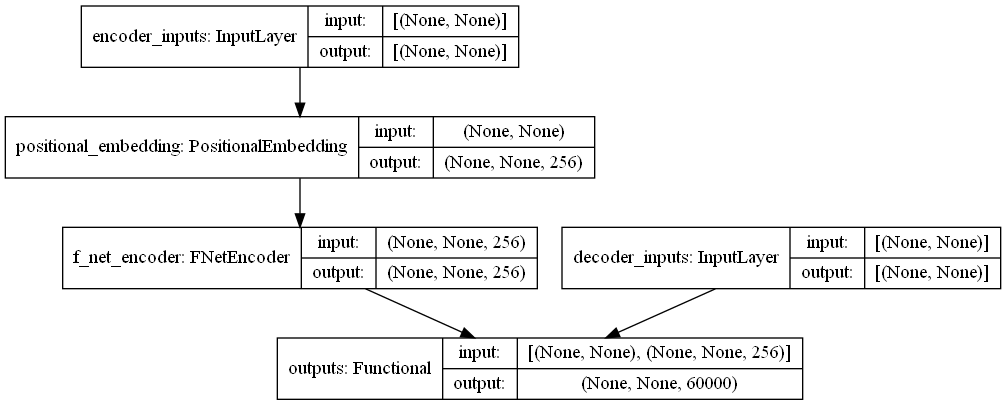

In [13]:
keras.utils.plot_model(fnet, show_shapes=True)

**Training**

In [14]:
fnet.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = fnet.fit(train_dataset, 
                   epochs=5, 
                   validation_data=val_dataset, 
                   callbacks=[early_stop])

Epoch 1/5
313/313 [==============================] - 97s 292ms/step - loss: 0.6459 - accuracy: 0.2913 - val_loss: 0.6067 - val_accuracy: 0.3176
Epoch 2/5
313/313 [==============================] - 90s 289ms/step - loss: 0.5271 - accuracy: 0.3547 - val_loss: 0.5812 - val_accuracy: 0.3286
Epoch 3/5
313/313 [==============================] - 90s 289ms/step - loss: 0.4692 - accuracy: 0.3890 - val_loss: 0.5767 - val_accuracy: 0.3283
Epoch 4/5
313/313 [==============================] - 90s 289ms/step - loss: 0.4202 - accuracy: 0.4237 - val_loss: 0.5776 - val_accuracy: 0.3287
Epoch 5/5
313/313 [==============================] - 90s 289ms/step - loss: 0.3750 - accuracy: 0.4610 - val_loss: 0.5927 - val_accuracy: 0.3194



Lowest Validation Loss: 0.5767 on epoch 3


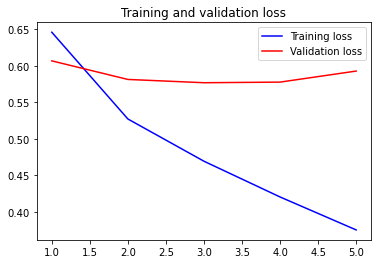

In [15]:
def plot_history(history):
    """This function plots the training and validation loss"""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.figure(figsize=(6,4))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    lowest_val_loss_epoch = np.argmin(val_loss)+1
    print("\nLowest Validation Loss: {:.4f} on epoch {}".format(np.min(val_loss), lowest_val_loss_epoch))
    
plot_history(history)

*Saving the model*

In [16]:
fnet.save('saved_models/FNet.h5')

*Loading the model*

In [17]:
fnet = tf.keras.models.load_model('saved_models/FNet.h5', 
                                  custom_objects={"FNetDecoder": FNetDecoder,
                                  "PositionalEmbedding": PositionalEmbedding, 
                                  "FNetEncoder":FNetEncoder})

### Making Inferences

In [18]:
VOCAB = vectorizer.get_vocabulary()

def decode_sentence(input_sentence):
    # Mapping the input sentence to tokens and adding start and end tokens
    tokenized_input_sentence = vectorizer(
        tf.constant("[start] " + preprocess_text(input_sentence) + " [end]")
    )
    # Initializing the initial sentence consisting of only the start token.
    tokenized_target_sentence = tf.expand_dims(VOCAB.index("[start]"), 0)
    decoded_sentence = ""

    for i in range(MAX_LENGTH):
        # Get the predictions
        predictions = fnet.predict(
            {
                "encoder_inputs": tf.expand_dims(tokenized_input_sentence, 0),
                "decoder_inputs": tf.expand_dims(
                    tf.pad(
                        tokenized_target_sentence,
                        [[0, MAX_LENGTH - tf.shape(tokenized_target_sentence)[0]]],
                    ),
                    0,
                ),
            }
        )
        # Calculating the token with maximum probability and getting the corresponding word
        sampled_token_index = tf.argmax(predictions[0, i, :])
        sampled_token = VOCAB[sampled_token_index.numpy()]
        # If sampled token is the end token then stop generating and return the sentence
        if tf.equal(sampled_token_index, VOCAB.index("[end]")):
            break
        decoded_sentence += sampled_token + " "
        tokenized_target_sentence = tf.concat(
            [tokenized_target_sentence, [sampled_token_index]], 0
        )

    return decoded_sentence

In [19]:
# Function for cleaning the test function output
def rem_double_q(input):
    loc1 = input.find('\"\"\"')
    loc2 = input.find('\"\"\"',loc1+3)
    return input[:loc1]+input[loc2+3:]

example = np.random.choice(np.arange(NUM_TRAINING_EXAMPLES + NUM_VALIDATION_EXAMPLES, df.shape[0]))

print("Actual Comment:", df['docstring_cleaned'][example])
print()
print("Predicted Comments:", decode_sentence(df['function_cleaned'][example]))
print()
print(f"Test Function:\n{rem_double_q(df['function'][example])}")

Actual Comment: associate a external ip

Predicted Comments: retrieve the configured ip of the ip of this client 

Test Function:
def associate_public_ip(self, instance_id, public_ip_id, private_ip=None):
        
        floating_ip = self.client.floating_ips.get(public_ip_id)
        floating_ip = floating_ip.to_dict()
        address = floating_ip.get('ip')

        self.client.servers.add_floating_ip(instance_id, address, private_ip)

        return True


*Testing on 5 random functions never seen before*

In [20]:
for _ in range(5):
    example = np.random.choice(np.arange(NUM_TRAINING_EXAMPLES + NUM_VALIDATION_EXAMPLES, df.shape[0]))
    print("#"*120)
    print("Actual Comment:", df['docstring_cleaned'][example])
    print()
    print("Predicted Comments:", decode_sentence(df['function_cleaned'][example]))
    print()
    print(f"Test Function:\n{rem_double_q(df['function'][example])}")

########################################################################################################################
Actual Comment: register a callback to be called when a presence stanza is received

Predicted Comments: register event handler 

Test Function:
def register_presence_callback(self, type_, from_, cb):
        
        type_ = self._coerce_enum(type_, structs.PresenceType)
        warnings.warn(
            "register_presence_callback is deprecated; use "
            "aioxmpp.dispatcher.SimplePresenceDispatcher or "
            "aioxmpp.PresenceClient instead",
            DeprecationWarning,
            stacklevel=2
        )
        self._xxx_presence_dispatcher.register_callback(
            type_,
            from_,
            cb,
        )
########################################################################################################################
Actual Comment: constructs a participantcontext

Predicted Comments: return a new client id for a new cli

**Making inferences on custom functions**

In [21]:
### Function for cleaning the functions for predictions
def clean_function(text):
    text_split = str(text).replace('\n',' ').replace('\t',' ').replace(',', ' , ').split()
    text = ' '.join(text_split)
    text = (text.replace('(', ' ( ').replace(')', ' ) ')
            .replace('=',' = ').replace('"', ' " ')
            .replace("'", " ' ").replace("#"," # ")
            .replace('[',' [ ').replace(']', ' ] ')
            .replace('{',' { ').replace('}', ' } ')
            .replace('+', ' + ').replace('-', ' - ')
            .replace(':', ' : ').replace('  ',' '))
    return text

In [40]:
actual_function = '''
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.figure(figsize=(6,4))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    lowest_val_loss_epoch = np.argmin(val_loss)+1
    print("\nLowest Validation Loss: {:.4f} on epoch {}".format(np.min(val_loss), lowest_val_loss_epoch))
'''

test_example = clean_function(actual_function)

print("Predicted Comments:", decode_sentence(test_example))
print()
print(f"Test Function:\n{actual_function}")

Predicted Comments: computes the loss of the given learning rate of the loss 

Test Function:

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.figure(figsize=(6,4))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    lowest_val_loss_epoch = np.argmin(val_loss)+1
    print("
Lowest Validation Loss: {:.4f} on epoch {}".format(np.min(val_loss), lowest_val_loss_epoch))

